In [1]:
%matplotlib inline


# Model Explanation

The following example shows how to fit a simple classification model with
*auto-sklearn* and use the [inspect module](https://scikit-learn.org/stable/inspection.html) from
scikit-learn to understand what affects the predictions.


In [2]:
import sklearn.datasets
from sklearn.inspection import plot_partial_dependence, permutation_importance
import matplotlib.pyplot as plt
import autosklearn.classification

/home/peng/opt/anaconda3/envs/autosl/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/peng/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.0' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


## Load Data and Build a Model

We start by loading the "Run or walk" dataset from OpenML and train an auto-sklearn model on it.
For this dataset, the goal is to predict whether a person is running or walking based on
accelerometer and gyroscope data collected by a phone. For more information see
[here](https://www.openml.org/d/40922).



In [3]:
dataset = sklearn.datasets.fetch_openml(data_id=40922)

# Note: To speed up the example, we subsample the dataset
dataset.data = dataset.data.sample(n=5000, random_state=1, axis="index")
dataset.target = dataset.target[dataset.data.index]

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    dataset.data, dataset.target, test_size=0.3, random_state=1
)

automl = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=120,
    per_run_time_limit=30,
    memory_limit=16384,
    tmp_folder="/tmp/autosklearn_inspect_predictions_example_tmp",
)
automl.fit(X_train, y_train, dataset_name="Run_or_walk_information")

s = automl.score(X_train, y_train)
print(f"Train score {s}")
s = automl.score(X_test, y_test)
print(f"Test score {s}")

/home/peng/opt/anaconda3/envs/autosl/lib/python3.9/site-packages/autosklearn/data/target_validator.py:187: UserWarning: Fitting transformer with a pandas series which has the dtype category. Inverse transform may not be able preserve dtype when converting to np.ndarray
  warnings.warn(


[WARNING] [2024-09-23 16:29:20,815:Client-AutoMLSMBO(1)::Run_or_walk_information] Dataset run_or_walk_information already in meta-data. Removing occurence.
Train score 0.9968571428571429
Test score 0.984


## Compute permutation importance - part 1

Since auto-sklearn implements the scikit-learn interface, it can be used with the scikit-learn's
inspection module. So, now we first look at the [permutation importance](https://christophm.github.io/interpretable-ml-book/feature-importance.html), which defines the
decrease in a model score when a given feature is randomly permuted. So, the higher the score,
the more does the model's predictions depend on this feature.

**Note:** There are some pitfalls in interpreting these numbers, which can be found
in the [scikit-learn docs](https://scikit-learn.org/stable/modules/permutation_importance.html).



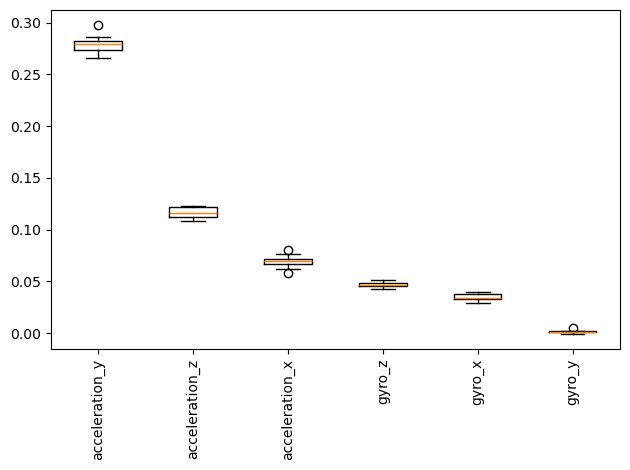

gyro_y    : 0.001 +/- 0.002
gyro_x    : 0.035 +/- 0.004
gyro_z    : 0.047 +/- 0.002
acceleration_x: 0.070 +/- 0.006
acceleration_z: 0.116 +/- 0.005
acceleration_y: 0.279 +/- 0.009


In [4]:
r = permutation_importance(automl, X_test, y_test, n_repeats=10, random_state=0)
sort_idx = r.importances_mean.argsort()[::-1]

plt.boxplot(
    r.importances[sort_idx].T, labels=[dataset.feature_names[i] for i in sort_idx]
)

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

for i in sort_idx[::-1]:
    print(
        f"{dataset.feature_names[i]:10s}: {r.importances_mean[i]:.3f} +/- "
        f"{r.importances_std[i]:.3f}"
    )

## Create partial dependence (PD) and individual conditional expectation (ICE) plots - part 2

[ICE plots](https://christophm.github.io/interpretable-ml-book/ice.html) describe the relation
between feature values and the response value for each sample
individually -- it shows how the response value changes if the value of one feature is changed.

[PD plots](https://christophm.github.io/interpretable-ml-book/pdp.html) describe the relation
between feature values and the response value, i.e. the expected
response value wrt. one or multiple input features. Since we use a classification dataset, this
corresponds to the predicted class probability.

Since ``acceleration_y`` and ``acceleration_z`` turned out to have the largest impact on the response
value according to the permutation dependence, we'll first look at them and generate a plot
combining ICE (thin lines) and PD (thick line)



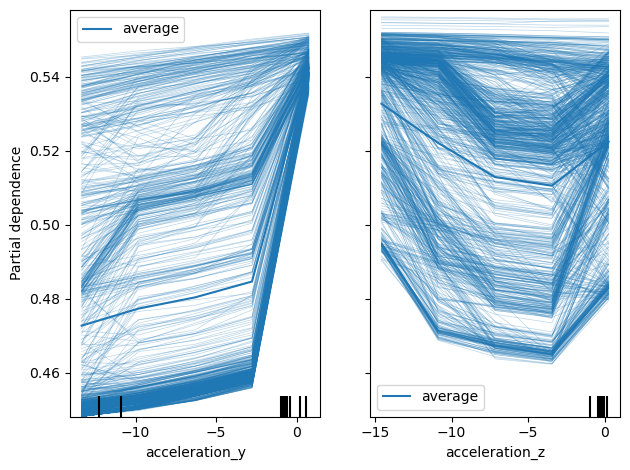

In [5]:
features = [1, 2]
plot_partial_dependence(
    automl,
    dataset.data,
    features=features,
    grid_resolution=5,
    kind="both",
    feature_names=dataset.feature_names,
)
plt.tight_layout()
plt.show()

## Create partial dependence (PDP) plots for more than one feature - part 3

A PD plot can also be generated for two features and thus allow to inspect the interaction between
these features. Again, we'll look at acceleration_y and acceleration_z.



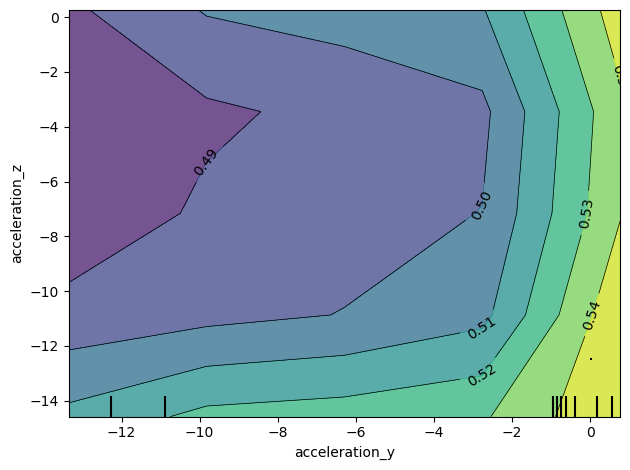

In [6]:
features = [[1, 2]]
plot_partial_dependence(
    automl,
    dataset.data,
    features=features,
    grid_resolution=5,
    feature_names=dataset.feature_names,
)
plt.tight_layout()
plt.show()